# ADM- HW4

In [1]:
from functions_final import *
import pandas as pd
import re

## Exercise 1: Hashing

For this exercise we were asked to implement a hash function and an algorithm called HyperLogLog (HLL), and test them on a specific dataset.

### 1.1 Hash Function

A hash function is any function that can be used to map data of arbitrary size to fixed-size values.\
A good hashing function distributes the input values evenly over the selected range, while ensuring that the so called collisions are not frequent.\
Our implementation follows these steps:

1. initialize a variable ('ans') to 0;
2. for each character in the string:\
    2.1 multiply 'ans' by a prime number (31 in our case);\
    2.2 convert the character to its Unicode integer representation;\
    2.3 add the integer representation to 'ans';
3. apply a modulo operation on 'ans', using the first prime number after 2^32 as modulus;
4. convert the result of the previous operation into a 32 bit binary string.

Step 2 allows us to get a pseudo random integer for each string, while the modulo operation distributes the values over 2^32 slots.

(you can find our implementation in the **functions.py** file)

### 1.2 HyperLogLog

HyperLogLog is an algorithm for the count-distinct problem, approximating the number of distinct elements in a multiset. It can be useful when dealing with huge datasets or in general when a precise estimate would be too expensive in terms of running time and memory usage.

The intuition behind this algorithm is that the cardinality of the multiset can be estimated by calculating the maximum number of leading zeros in the binary representation of each number in the set: the higher is the cardinality of the multiset, the higher the maximum number of leading zeros that we expect to find.\
The input values are processed in buckets called registers that only keep track of the maximum number of leading zeros seen so far, then the maximum length of the leading zeros sequence for each register is used to estimate the cardinality.

We decided to select the first 12 bits of the hashed inputs to identify the register, which means that we have 2^12 registers in total.

Our implementation can be split in two parts:
1. Registers processing
2. Cardinality estimation

In part 1, we read the dataset sequentially, applying the hash function on each row, identifying the corresponding register and counting the leading zeros. We update the maximum value for each register every time we find a maximum.

In part 2, we compute the harmonic mean of the maximum leading zeros and do some other mathematical operations to estimate the cardinality.

As we can see the estimated value is 125,846,739.

We also know, from experimental results, that the expected error is $\frac{1.3}{\sqrt{m}}$ where m is the number of registers. In our case, that equals to around 4 %.

*Bonus: we also calculated the precise estimate using a more powerful machine (32 GB RAM AWS EC2 instance) and the result was 25.000.000. Our estimate is very close to that value and the error is well within the expected range.

In [2]:
registers = createRegisters()

NameError: name 'createRegisters' is not defined

In [ ]:
process_data(registers)

In [ ]:
hyperLogLog(registers)

In [ ]:
errorFilter()

## Exercise 2: Clustering

For this exercise we were asked to implement a k-means algorithm from scratch and use it to cluster the products from a fine foods reviews dataset.

We are only interested on the plain text of the reviews.

### 2.1 Preprocessing

In [2]:
df = pd.read_csv('./Reviews.csv', sep=",", usecols = [i for i in range(1,10)])

In [3]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


We drop some anomalous data

In [5]:
df = df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"], keep='first', inplace=False)
df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]] # remove the numerator greater than denominator

We fill the null values with 0

In [6]:
df.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

In [7]:
df['ProfileName'].fillna('', inplace=True)
df['Summary'].fillna('', inplace=True)

In [8]:
df.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We create a new dataframe from the first one, grouping by productId and concatenating the text column for each review.

In [9]:
product_id_df = groupby_productid_df(df)

In [10]:
import re

In [11]:
product_id_df["reviews"] = [clean_text(x) for x in list(product_id_df["reviews"])]
product_id_df.head()

,ProductId,reviews
0,0006641040,"[day, person, say, chicken, soup, probabl, go,..."
1,141278509X,"[product, archer, farm, best, drink, mix, ever..."
2,2734888454,"[dog, love, chicken, product, china, wont, buy..."
3,2841233731,"[book, easi, read, ingredi, avail, store, unli..."
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,..."


We now convert our dataframe in a sparse matrix with the tfidf scores, removing the least frequent words

In [12]:
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, min_df = 0.01)
tfidf_matrix = tfidf.fit_transform(product_id_df["reviews"])

We are left with 1,730 distinct words

In [13]:
len(tfidf.vocabulary_)

1730

#####ADD COMMENT######

In [14]:
tfidf_matrix = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)

In [15]:
tfidf_matrix

,0,1,2,3,4,5,6,7,8,9,...,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729
0,0.013453,0.006685,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010785,...,0.0,0.007167,0.0,0.010671,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.191613,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67619,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67620,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67621,0.000000,0.000000,0.330778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67622,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


We now apply the SVD method to reduce the dimensionality of our dataset, using 350 components. As we can see, the explained variance is just above 60 %.

In [16]:
svd = TruncatedSVD(n_components=350)
preprocessed_data = svd.fit_transform(tfidf_matrix)
print(svd.explained_variance_ratio_.sum()*100)

61.046465743921765


We are now ready to implement our kmeans algorithm and run it on our data.

### 2.2 Kmeans implementation

Our model works like this:

1. We first specify how many clusters we want (k)
2. We randomly select k rows from our sparse matrix (after SVD) and set them as the first centroids.
3. We iterate over each row in our sparse matrix, calculating the distance from each centroid and assigning the point (row) to the closest centroid (for each centroid we have a cluster)
4. We take the average of all points in each cluster, finding the coordinates of our new centroids
5. We repeat step 3-4 until the clusters stop changing (or until we reach 100 iterations)

Our implementation uses Python OOP (object oriented programming). See **functions_final.py** for the source code.

We first create an instance of our Kmeans model:

In [17]:
model_test = my_Kmeans(5)

Then we use the fit function to run the model and output a list of the cluster labels for each data point

In [18]:
cluster_labels = model_test.fit(preprocessed_data)

iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
iteration no. 33
iteration no. 34
iteration no. 35
iteration no. 36
iteration no. 37
iteration no. 38
iteration no. 39
iteration no. 40
iteration no. 41
iteration no. 42
iteration no. 43
iteration no. 44
iteration no. 45
iteration no. 46
iteration no. 47
iteration no. 48
iteration no. 49
iteration no. 50
iteration no. 51
iteration no. 52
iteration no. 53
iteration no. 54
iteration no. 55
iteration no. 56
iteration no. 57
iteration no. 58
iterati

After 62 iterations the algortithm converged. Let's see the labels:

In [20]:
cluster_labels[:10]

[0, 0, 1, 0, 2, 1, 0, 2, 2, 2]

We are now interested in finding the optimal number of cluster. To do so, we use the so called Elbow Method.

To apply this method we first need to compute, for different number of clusters, the sum of the squared distance between each point and its closest centroid.

We created a method called 'inertia' inside our Kmeans class that performs this operation after fitting the model.  

In [88]:
elbow = {}

for i in range (5,70,5):
    print('k = {0}'.format(i))
    model_test = Kmeans(i)
    result = model_test.fit(new_dn)
    elbow[i] = model_test.inertia(new_dn)

k = 5
iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
k = 10
iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
iteration no. 33
iter

We can now use a line plot to visualize the relation between the number of clusters and the sum of the squared distance:\
######FIX PLOT######

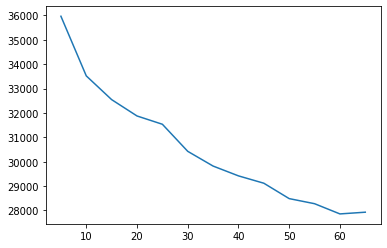

In [90]:
plt.plot(list(elbow.keys()), list(elbow.values()))

## Exercise 3